In [3]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 62.6 MB/s eta 0:00:0000:0100:01


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load image pair
img1 = cv2.imread('4_a.png')  
img2 = cv2.imread('4_b.png')  

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

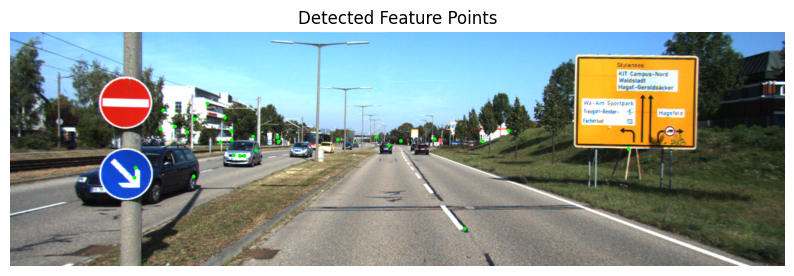

In [4]:
# Shi-Tomasi corner detector parameters
feature_params = dict(
    maxCorners=200,      
    qualityLevel=0.6,     
    minDistance=6,        
    blockSize=3           
)

# Detect corners in the first image
corners = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# Create a copy of the image 
vis_img = img1.copy()

# Draw circles at corner points
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(vis_img, (int(x), int(y)), 3, (0, 255, 0), -1)

# Display the image with corners
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title('Detected Feature Points')
plt.axis('off')
plt.show()

Number of keypoints in motion: 29
Number of keypoints after thresholding: 24


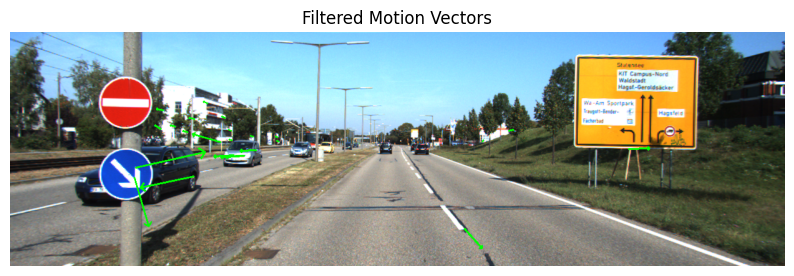

In [5]:
def estimate_motion_vectors(img1, img2, feature_points):
    # Convert images to grayscale if they aren't already
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        gray1 = img1
        gray2 = img2
    
    # Define parameters for Lucas-Kanade optical flow
    lk_params = dict(
        winSize=(8, 8),  # Size of the search window at each pyramid level
        maxLevel=5,      # Maximum pyramid level
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)  # Termination criteria
    )
    
    # Calculate optical flow
    points2, status, error = cv2.calcOpticalFlowPyrLK(
        gray1, gray2, feature_points, None, **lk_params
    )
    
    return points2, status, error

def get_valid_motion_vectors(points1, points2, status):
    # Keep only points that were successfully tracked (status == 1)
    valid_points1 = points1[status == 1]
    valid_points2 = points2[status == 1]
    
    print(f"Number of keypoints in motion: {valid_points1.shape[0]}")
    
    # Calculate motion vectors
    motion_vectors = valid_points2 - valid_points1
    
    return valid_points1, valid_points2, motion_vectors

def filter_motion_vectors(points1, points2, motion_vectors):
    # Calculate vector magnitudes
    magnitudes = np.linalg.norm(motion_vectors, axis=1)
    
    # Define thresholds
    lower_bound = 2  # Minimum motion (in pixels)
    upper_bound = 10  # Optional: Maximum motion (in pixels)
    
    # Filter points with significant motion
    mask = magnitudes > lower_bound
    filtered_points1 = points1[mask]
    filtered_points2 = points2[mask]
    filtered_vectors = motion_vectors[mask]
    
    print(f"Number of keypoints after thresholding: {filtered_points1.shape[0]}")
    
    return filtered_points1, filtered_points2, filtered_vectors

def visualize_motion_vectors(image, start_points, end_points, color=(0, 255, 0), thickness=2):
    """Draw motion vectors as arrows on the image"""
    vis_img = image.copy()
    
    for i in range(start_points.shape[0]):
        # Convert points to integer tuples
        start_point = tuple(map(int, start_points[i]))
        end_point = tuple(map(int, end_points[i]))
        
        # Draw arrow from start to end point
        vis_img = cv2.arrowedLine(vis_img, start_point, end_point, color, thickness)
    
    return vis_img

# Step 1: Estimate motion vectors
points2, status, error = estimate_motion_vectors(img1, img2, corners)

# Step 2: Get valid motion vectors
valid_points1, valid_points2, motion_vectors = get_valid_motion_vectors(corners, points2, status)

# Step 3: Filter motion vectors (by magnitude)
filtered_points1, filtered_points2, filtered_vectors = filter_motion_vectors(valid_points1, valid_points2, motion_vectors)

# Step 4: Visualize motion vectors
vis_img = visualize_motion_vectors(img1, filtered_points1, filtered_points2)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title('Filtered Motion Vectors')
plt.axis('off')
plt.show()